# Distribution analysis, whitening

## Preparations

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data._utils.collate import default_collate
from pathlib import Path
from tqdm import tqdm
from itertools import chain
from torchvision.datasets import CocoDetection
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from scipy.linalg import svdvals
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 90

In [11]:
if not Path('/content/embeddings/').exists():
    ! git clone https://github.com/Reason239/multimodal-embeddings-analysis.git
    ! cp -a /content/multimodal-embeddings-analysis/. /content/
    ! rm -rf /content/multimodal-embeddings-analysis
    # Gdrive fails sometimes
    # ! mkdir -p /content/embeddings/
    # # ~1 Gb download
    # ! gdown https://drive.google.com/drive/folders/1DnyubYHyKRI5Xm_LArzI5Si7rKzoyGU-?usp=sharing -O /content/ --folder

Cloning into 'multimodal-embeddings-analysis'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 158 (delta 0), reused 0 (delta 0), pack-reused 155
Receiving objects: 100% (158/158), 420.78 MiB | 23.20 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Checking out files: 100% (31/31), done.


In [12]:
image_embeddings = torch.load(f'/content/embeddings/coco_val2014/image/rudolph.pt', map_location='cpu')

In [13]:
def centered(embedding_matrix):
    return embedding_matrix - embedding_matrix.mean(0)

def normed(embedding_matrix):
    if isinstance(embedding_matrix, torch.Tensor):
        return embedding_matrix / embedding_matrix.norm(dim=-1, keepdim=True) 
    return embedding_matrix / np.linalg.norm(embedding_matrix, axis=-1, keepdims=True)

In [14]:
image_embeddings.shape

torch.Size([25000, 1024])

Isotropy measures

$I_1, I_2$ metrics, coordinates std plots

In [25]:
def get_eigen_vectors(input):
    return torch.real(torch.eig(input, eigenvectors=True)[1])

def Z(matrix, vector):
    return torch.exp((matrix * vector).sum(dim=1)).sum()

def get_isotropy_1(embeddings):
    eigen_vectors = get_eigen_vectors(torch.transpose(embeddings, 0, 1) @ embeddings)

    min_z = Z(embeddings, eigen_vectors[0])
    max_z = min_z
    for eigen_vector in eigen_vectors[1:]:
        z = Z(embeddings, eigen_vector)
        min_z = z if z < min_z else min_z
        max_z = z if z > max_z else max_z
    return float((min_z / max_z).numpy())

def get_isotropy_2(embeddings):
    eigen_vectors = get_eigen_vectors(torch.transpose(embeddings, 0, 1) @ embeddings)

    all_z = []
    for eigen_vector in eigen_vectors:
        all_z.append(float(Z(embeddings, eigen_vector).numpy()))
    variance = np.var(all_z)
    mean = np.mean(all_z)
    return np.sqrt(variance / mean ** 2)

def plot_std_dims_distribution(embeddings, label):
    std_dims = torch.std(embeddings, dim=0)
    # sns.distplot(std_dims, kde=False, norm_hist=True, label=label)
    plt.hist(std_dims, bins='rice', edgecolor='none', density=True, alpha=0.5, label=label)

In [26]:
get_isotropy_1(normed(torch.randn(1000, 10))), get_isotropy_1(normed(torch.rand(1000, 10)) + 1)

(0.9678486585617065, 0.014343945309519768)

In [27]:
get_isotropy_2(normed(torch.randn(1000, 10))), get_isotropy_2(normed(torch.rand(1000, 10)) + 1)

(0.009631252518946311, 1.0290415987526573)

Visualization using first 2 SVD components

In [28]:
def embedding_visualisation(embedding_matrix, centering=False, divide=False):
    if centering:
        embedding_matrix = centered(embedding_matrix)
    svd = TruncatedSVD(n_components=2)
    svd.fit(embedding_matrix)
    comp_tr = np.transpose(svd.components_)
    proj = np.dot(embedding_matrix, comp_tr)

    svs = svdvals(embedding_matrix)
    svs /= svs.max()

    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    if not divide:
        plt.scatter(proj[:, 0], proj[:, 1], s=1, alpha=0.1)
    else:
        half = embedding_matrix.shape[0] // 2
        plt.scatter(proj[:half, 0], proj[:half, 1], s=1, alpha=0.1, label='image')
        plt.scatter(proj[half:, 0], proj[half:, 1], s=1, alpha=0.1, label='text')
        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    plt.scatter([0], [0], c='r', marker='+', s=100)
    plt.axis('scaled')
    plt.xlabel('SVD component 1')
    plt.ylabel('SVD component 2')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(svs)), svs)
    plt.ylim(-0.1, 1.1)
    plt.xlabel('Index')
    plt.ylabel('Normalized Singular Value')

    return proj, svs

Whitening

In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
if not Path('whitening.py').exists():
    ! wget https://raw.githubusercontent.com/Reason239/multimodal-embeddings-analysis/main/whitening.py

In [22]:
from whitening import Whitener

In [23]:
@torch.no_grad()
def whiten_embeddings(embedding_matrix, k=2):
    embedding_matrix = torch.FloatTensor(embedding_matrix)
    whitener = Whitener(embedding_matrix.shape[1], k)
    whitener.compute_parameters(embedding_matrix)
    return whitener(embedding_matrix)

In [24]:
whitening_k = 128

## Norms and cosine similarities distributions

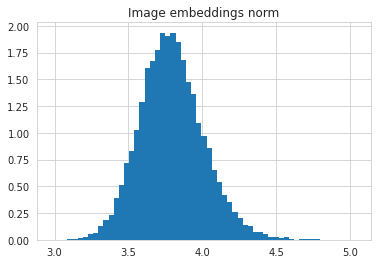

In [29]:
plt.hist(image_embeddings.norm(dim=-1).cpu(), bins='rice', edgecolor='none', density=True)
plt.title('Image embeddings norm')
plt.show()

CLIP uses cosine similarity, so norms have no meaning, so we normalize the embeddings

In [30]:
image_embeddings = normed(image_embeddings)
image_embeddings_np = image_embeddings.cpu().numpy()

In [31]:
image_batch = image_embeddings[:1024]

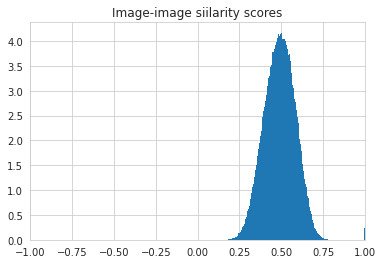

In [32]:
plt.hist((image_batch @ image_batch.T).cpu().reshape(-1), bins='rice', edgecolor='none', density=True)
plt.xlim(-1, 1)
plt.title('Image-image siilarity scores')
plt.show()

In [33]:
image_batch_centered = centered(image_batch)
image_batch_centered_normed = normed(image_batch_centered)

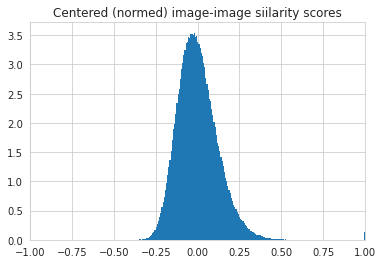

Mean cosine similarity: 0.00026225263718515635


In [34]:
scores = (image_batch_centered_normed @ image_batch_centered_normed.T).cpu().reshape(-1)
plt.hist(scores, bins='rice', edgecolor='none', density=True)
plt.xlim(-1, 1)
plt.title('Centered (normed) image-image siilarity scores')
plt.show()
print(f'Mean cosine similarity: {scores.mean()}')

## Image and text embeddings distributions

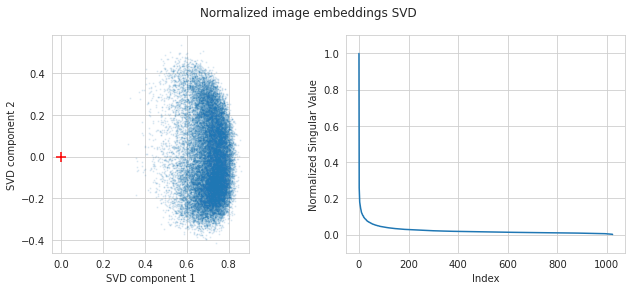

I_1 metric: 0.86
I_2 metric: 0.02


In [35]:
name = 'Normalized image embeddings'
embedding_visualisation(image_embeddings_np)
plt.suptitle(f'{name} SVD')
plt.show()
print(f'I_1 metric: {get_isotropy_1(image_embeddings):.2f}')
print(f'I_2 metric: {get_isotropy_2(image_embeddings):.2f}')

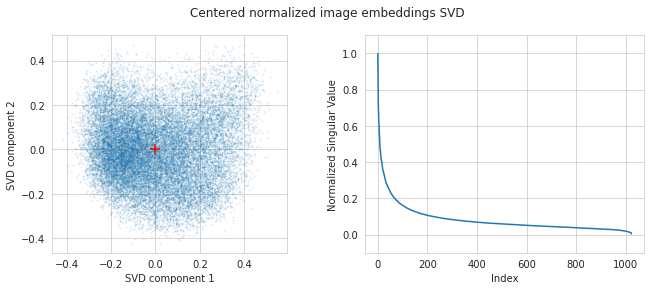

I_1 metric: 1.00
I_2 metric: 0.00


In [36]:
name = 'Centered normalized image embeddings'
embedding_visualisation(image_embeddings_np, centering=True)
plt.suptitle(f'{name} SVD')
plt.show()
print(f'I_1 metric: {get_isotropy_1(normed(centered(image_embeddings))):.2f}')
print(f'I_2 metric: {get_isotropy_2(normed(centered(image_embeddings))):.2f}')

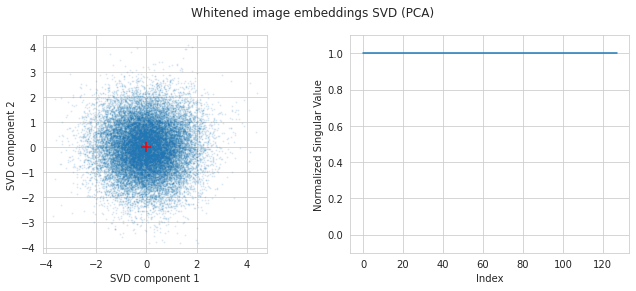

I_1 metric: 1.00
I_2 metric: 0.00


In [37]:
name = 'Whitened image embeddings'
image_embeddings_whitened = whiten_embeddings(image_embeddings_np, whitening_k)
proj, svs = embedding_visualisation(image_embeddings_whitened)
plt.suptitle(f'{name} SVD (PCA)')
plt.show()
print(f'I_1 metric: {get_isotropy_1(normed(image_embeddings_whitened)):.2f}')
print(f'I_2 metric: {get_isotropy_2(normed(image_embeddings_whitened)):.2f}')

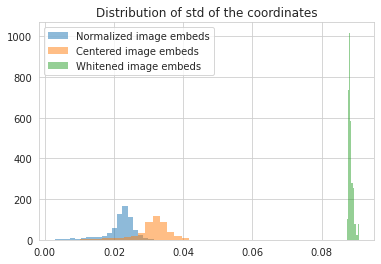

In [38]:
plot_std_dims_distribution(normed(image_embeddings), 'Normalized image embeds')
plot_std_dims_distribution(normed(centered(image_embeddings)), 'Centered image embeds')
plot_std_dims_distribution(normed(image_embeddings_whitened), 'Whitened image embeds')
plt.legend()
plt.title('Distribution of std of the coordinates')
plt.show()